# Dead Leaves - Synthetic Images Generation

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import load_data, store_dl_disk
from skimage.morphology import disk, ellipse, square
from multiprocessing import Pool
from dead_leave_generator import *

%load_ext autoreload
%autoreload 2

## CT Images Stats

In [2]:
ct_stat_results = np.load('data_stats_analysis/ct_stat_results.npz')

## Generation

In [3]:
# Number of core cpu your machine has
cpu_core = 60

# Total number of Dead Leaves images to compute. Note that we only compute 13'301 DL images since
# a test batch is not required. We test performance of models on CT.
nb_dl_images = 13301  # 13301

# Arguments for the Dead Leaves generation
dl_args = {
    'alpha': abs(ct_stat_results['alpha']-0.3),
    'r_min': 1,
    'r_max': 512,
    'color_distribution': ct_stat_results['color_distribution'],
    'width': 512,
    'height': 512,
    'max_objects': 50000
}

# Creation of tuple to give to the Dead Leaves generator
nb_dl_images_per_cpu = int(nb_dl_images / cpu_core + 0.5)
infos = (nb_dl_images_per_cpu, dl_args)

# Compute the Dead Leaves images in parallel in each given core cpu
pool = Pool(cpu_core)
results = pool.map(dead_leaves_generator, [infos for _ in range(cpu_core)])

Group the Dead Leaves images in one `GroupSynth` class.

In [4]:
dead_leaves = results[0]
for result in results[1:]:
    dead_leaves.imgs += result.imgs
dead_leaves.len = len(dead_leaves.imgs)

Look at the dead leaves generated.

Radius min:  1
Radius max:  512
Alpha used:  1.9678
Number of images:  13320
----------- idx: 0 -----------
Disk number:  2055
Width:  512
Height:  512
Radius mean:  7.842335766423358
Ratio drawn: 99.82%


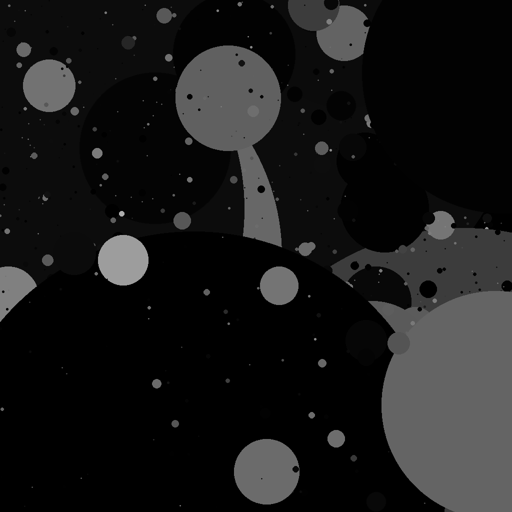

In [5]:
idx = 0

print("Radius min: ", dead_leaves.r_min)
print("Radius max: ", dead_leaves.r_max)
print("Alpha used: ", dead_leaves.alpha)
print("Number of images: ", dead_leaves.len)
print(f"----------- idx: {idx} -----------")
print("Disk number: ", dead_leaves.imgs[idx].disk_number)
print("Width: ", dead_leaves.imgs[idx].width)
print("Height: ", dead_leaves.imgs[idx].height)
print("Radius mean: ", dead_leaves.imgs[idx].r_mean)
print(f"Ratio drawn: {dead_leaves.imgs[idx].ratio_drawn*100:.2f}%")
dead_leaves.imgs[idx].pil

## Statistical Overview

Look at some statistical image metric to check if you mimic the ones of a CT image.

### Color Distribution

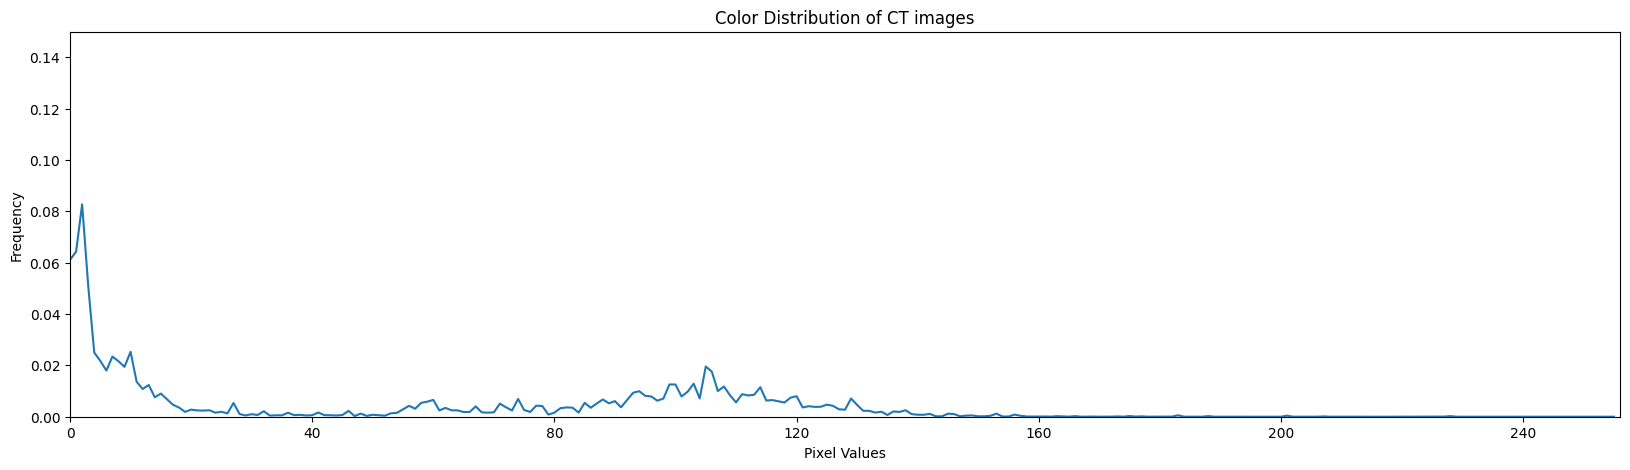

In [6]:
dl_color_hist = dead_leaves.color_histogram(plot=True)

### Directional Gradient

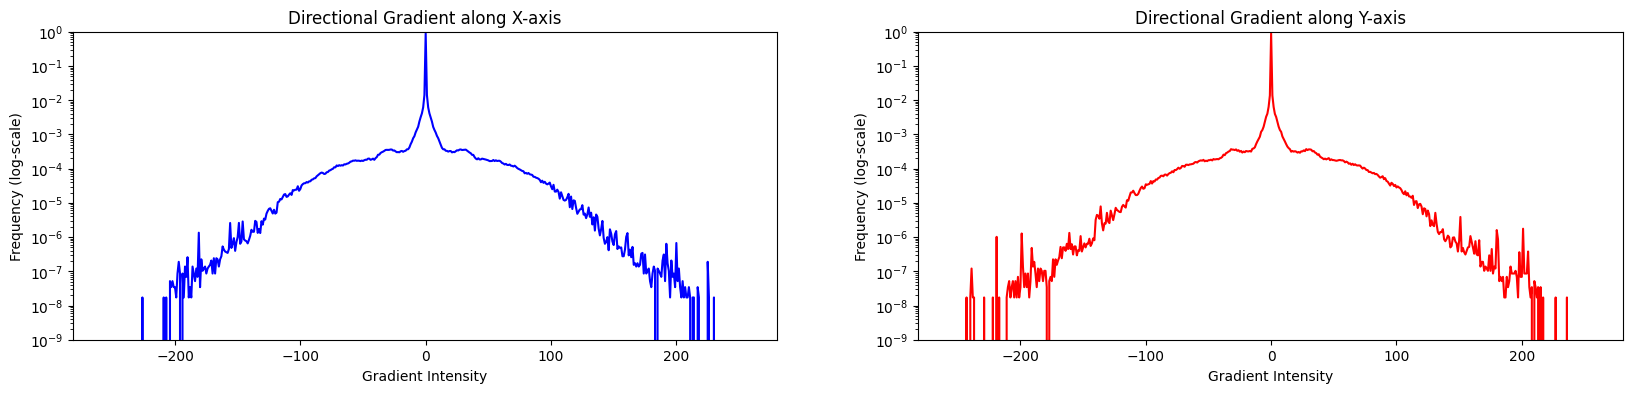

In [7]:
dl_grad_dist_x, dl_grad_dist_y, dl_grad_intensity = dead_leaves.directional_gradient(plot=True)

### Fourier Analysis

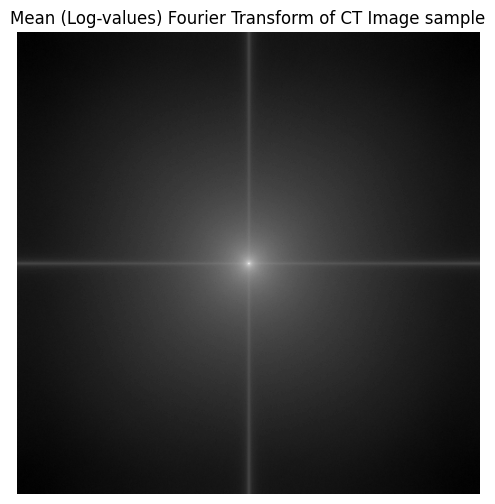

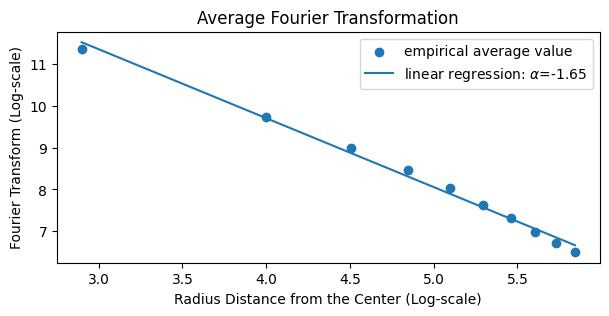

In [8]:
dl_alpha = dead_leaves.fourier_transform_analysis(plot=True)

## Store DL images

In [9]:
# Fix the path to store the dl images
path = "data/train/dl_images_bis/"
 
# Store the image in disk
store_dl_disk(path, dead_leaves.imgs)

Writing generated Dead Leaves into disk:   0%|          | 0/13320 [00:00<?, ?it/s]